In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# ! pip install pgmpy

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np

import common

In [5]:
date_set_path = "../temp_sets_100/"

## admissions

### Read samples

In [6]:
admissions_df = common.read_csv_no_rowid(date_set_path+"admissions.csv")

### Data preproces

In [7]:
# Drop useless colums
admissions_df.drop(['diagnosis', 'hospital_expire_flag'], axis=1, inplace=True)

#### Deal with null values

In [8]:
# Check null value in table
common.nan_count(admissions_df)

Total columns: 16
Total rows: 123
--------------
subject_id                0
hadm_id                   0
admittime                 0
dischtime                 0
deathtime               112
admission_type            0
admission_location        0
discharge_location        0
insurance                 0
language                 52
religion                  1
marital_status           18
ethnicity                 0
edregtime                66
edouttime                66
has_chartevents_data      0
dtype: int64


In [9]:
# Set a value replacing the null time value
# nan_datetime=pd.to_datetime(0)

In [10]:
# admissions_df['dob'].fillna(value=nan_datetime, inplace=True)
# admissions_df['dod_hosp'].fillna(value=nan_datetime, inplace=True)
# admissions_df['dod_ssn'].fillna(value=nan_datetime, inplace=True)

In [11]:
common.nan_count(admissions_df)

Total columns: 16
Total rows: 123
--------------
subject_id                0
hadm_id                   0
admittime                 0
dischtime                 0
deathtime               112
admission_type            0
admission_location        0
discharge_location        0
insurance                 0
language                 52
religion                  1
marital_status           18
ethnicity                 0
edregtime                66
edouttime                66
has_chartevents_data      0
dtype: int64


#### Set the column types

In [12]:
admissions_df.dtypes

subject_id               int64
hadm_id                  int64
admittime               object
dischtime               object
deathtime               object
admission_type          object
admission_location      object
discharge_location      object
insurance               object
language                object
religion                object
marital_status          object
ethnicity               object
edregtime               object
edouttime               object
has_chartevents_data     int64
dtype: object

In [13]:
# Transfer some date type
admissions_df['admittime'] = pd.to_datetime(admissions_df['admittime'])
admissions_df['dischtime'] = pd.to_datetime(admissions_df['dischtime'])
admissions_df['deathtime'] = pd.to_datetime(admissions_df['deathtime'])
admissions_df['edregtime'] = pd.to_datetime(admissions_df['edregtime'])
admissions_df['edouttime'] = pd.to_datetime(admissions_df['edouttime'])

In [14]:
admissions_df.dtypes

subject_id                       int64
hadm_id                          int64
admittime               datetime64[ns]
dischtime               datetime64[ns]
deathtime               datetime64[ns]
admission_type                  object
admission_location              object
discharge_location              object
insurance                       object
language                        object
religion                        object
marital_status                  object
ethnicity                       object
edregtime               datetime64[ns]
edouttime               datetime64[ns]
has_chartevents_data             int64
dtype: object

#### Deal with some special value

In [15]:
admissions_df.loc[113]

subject_id                                   97263
hadm_id                                     164631
admittime                      2122-01-15 22:31:00
dischtime                      2122-01-20 20:30:00
deathtime                      2122-01-21 20:30:00
admission_type                           EMERGENCY
admission_location       CLINIC REFERRAL/PREMATURE
discharge_location                    DEAD/EXPIRED
insurance                                  Private
language                                      ENGL
religion                              UNOBTAINABLE
marital_status                            DIVORCED
ethnicity               PATIENT DECLINED TO ANSWER
edregtime                      2122-01-15 21:12:00
edouttime                      2122-01-16 01:56:00
has_chartevents_data                             1
Name: 113, dtype: object

In [16]:
admissions_df = admissions_df.drop(admissions_df.loc[(pd.isna(admissions_df['deathtime']) == False) & (admissions_df['dischtime'] != admissions_df['deathtime'])].index)

---

##  Build Network

In [17]:
from sdv.tabular import CTGAN
from sdv.constraints import FixedCombinations
from sdv.constraints import create_custom_constraint

In [18]:
admissions_df.columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
       'edregtime', 'edouttime', 'has_chartevents_data'],
      dtype='object')

### Set constraint

In [19]:
def time_is_valid(column_names, data):
    admit_disch = (data['admittime'] <= data['dischtime']) & ((data['dischtime'] - data['admittime']).apply(lambda x: 0 <= x.days  <= 365))

    edreg_admit = \
        (pd.isna(data['edregtime']) & pd.isna(data['edouttime'])) | \
        ( \
            ((pd.isna(data['edregtime']) == False) & (pd.isna(data['edouttime']) == False)) & \
            ((data['admittime'] - data['edregtime']).apply(lambda x: 0 <= x.days  <= 1)) \
        )

    # admit_edout = (pd.isna(admissions_df['edregtime'])) | (admissions_df['admittime'] <= admissions_df['edouttime'])

    edout_disch = \
        (pd.isna(data['edregtime']) & pd.isna(data['edouttime'])) | \
        ( \
            ((pd.isna(data['edregtime']) == False) & (pd.isna(data['edouttime']) == False)) & \
            ((data['dischtime'] - data['edouttime']).apply(lambda x: 0 <= x.days  <= 365)) \
        )

    # disch_death = (pd.isna(data['deathtime'])) | ((pd.isna(data['deathtime']) == False) & (data['dischtime'] == data['deathtime']))        
    
    return admit_disch & edreg_admit & edout_disch

In [20]:
def time_trasform(column_names, data):
    # print(data.loc[:, ['dod', 'dod_hosp', 'dod_ssn']])
    return data

def time_reverse_transform(column_names, transformed_data):

    is_death = (pd.isna(transformed_data['deathtime']) == False)
    transformed_data.loc[is_death, ['deathtime']] = transformed_data[is_death]['dischtime'].values
    transformed_data['deathtime'] = pd.to_datetime(transformed_data['deathtime'])

    return transformed_data

In [21]:
TimeProcess = create_custom_constraint(
    is_valid_fn=time_is_valid,
    transform_fn=time_trasform,
    reverse_transform_fn=time_reverse_transform
)

In [22]:
time_constraint = TimeProcess(
    column_names=['admittime', 'dischtime','edregtime', 'edouttime', 'deathtime']
)

In [23]:
constrains = [time_constraint]

### Build model

In [42]:
model = CTGAN(
    constraints=constrains, 
    generator_lr=0.0005,
    batch_size=10000,
    cuda=True, 
    verbose=True, 
    epochs=60)

In [43]:
len(admissions_df)

122

In [44]:
train_data = admissions_df
model.fit(train_data)

Epoch 1, Loss G:  1.6460,Loss D: -0.0081
Epoch 2, Loss G:  1.5896,Loss D: -0.0353
Epoch 3, Loss G:  1.5417,Loss D: -0.0677
Epoch 4, Loss G:  1.5017,Loss D: -0.0897
Epoch 5, Loss G:  1.4208,Loss D: -0.1165
Epoch 6, Loss G:  1.3630,Loss D: -0.1269
Epoch 7, Loss G:  1.3014,Loss D: -0.1383
Epoch 8, Loss G:  1.2087,Loss D: -0.1325
Epoch 9, Loss G:  1.1061,Loss D: -0.1309
Epoch 10, Loss G:  1.0101,Loss D: -0.1500
Epoch 11, Loss G:  0.9237,Loss D: -0.1355
Epoch 12, Loss G:  0.8112,Loss D: -0.1127
Epoch 13, Loss G:  0.7018,Loss D: -0.0998
Epoch 14, Loss G:  0.5993,Loss D: -0.0839
Epoch 15, Loss G:  0.5125,Loss D: -0.0438
Epoch 16, Loss G:  0.4254,Loss D:  0.0214
Epoch 17, Loss G:  0.3325,Loss D:  0.0535
Epoch 18, Loss G:  0.2619,Loss D:  0.1111
Epoch 19, Loss G:  0.1684,Loss D:  0.1974
Epoch 20, Loss G:  0.1046,Loss D:  0.2261
Epoch 21, Loss G:  0.0836,Loss D:  0.2434
Epoch 22, Loss G:  0.1093,Loss D:  0.2781
Epoch 23, Loss G:  0.1496,Loss D:  0.2323
Epoch 24, Loss G:  0.1773,Loss D:  0.2174
E

In [46]:
import cloudpickle

with open(date_set_path + "100_models/" + "admissions_model.pkl", 'wb') as f:
    cloudpickle.dump(model, f)

In [29]:
import cloudpickle

with open(date_set_path + "100_models/" + "admissions_model.pkl", 'rb') as f:
    loaded_model = cloudpickle.load(f)

In [ ]:
# model.save(date_set_path + "100_models/" + "admissions_model.pkl")

In [ ]:
sample = model.sample(100)

Sampling rows: 100%|██████████| 100/100 [00:09<00:00, 10.41it/s]


In [ ]:
# Add some original columns
sample['hospital_expire_flag'] = sample['deathtime'].apply(lambda x: 0 if pd.isna(x) else 1)

In [ ]:
sample.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,has_chartevents_data,hospital_expire_flag
0,7055,100223,2145-05-23 04:04:00,2145-11-29 19:18:00,NaT,EMERGENCY,PHYS REFERRAL/NORMAL DELI,HOME,Medicare,NaN,CATHOLIC,SINGLE,WHITE,NaT,NaT,1,0
1,56955,104314,2132-02-25 12:06:00,2132-08-17 03:01:00,NaT,ELECTIVE,EMERGENCY ROOM ADMIT,HOME,Medicaid,RUSS,CATHOLIC,SINGLE,WHITE,NaT,NaT,1,0
2,12832,100223,2135-04-30 18:14:00,2135-05-02 08:22:00,2135-05-02 08:22:00,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicaid,ENGL,CATHOLIC,MARRIED,WHITE,NaT,NaT,1,1
3,25713,143754,2110-03-26 23:27:00,2111-01-08 20:03:00,NaT,EMERGENCY,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,NaT,NaT,1,0
4,569,162014,2116-03-16 22:47:00,2116-05-09 11:08:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicaid,NaN,UNOBTAINABLE,WIDOWED,BLACK/HAITIAN,NaT,NaT,1,0


In [ ]:
sample.to_csv("test.csv")

In [ ]:
train_data.to_csv("test.csv")

### Process the generated data

---

## Evaluate data

In [ ]:
from sdv.evaluation import evaluate

In [ ]:
train_data.columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
       'edregtime', 'edouttime', 'has_chartevents_data'],
      dtype='object')

In [ ]:
evaluate(sample.drop(['hospital_expire_flag'], axis=1), train_data, metrics=['DiscreteKLDivergence'])

0.40531113272964897

In [ ]:
evaluate(sample.drop(['hospital_expire_flag'], axis=1), train_data, metrics=['ContinuousKLDivergence'])

0.5400340429220125

In [ ]:
evaluate(sample.drop(['hospital_expire_flag'], axis=1), train_data)

0.6445925116054743

In [ ]:
sample['admission_type'].value_counts()

EMERGENCY    72
NEWBORN      13
ELECTIVE     12
URGENT        3
Name: admission_type, dtype: int64

<AxesSubplot:>

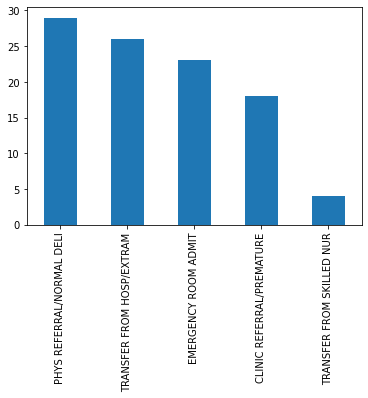

In [ ]:
sample['admission_location'].value_counts().plot.bar()

In [ ]:
train_data['admission_type'].value_counts()

EMERGENCY    89
ELECTIVE     17
NEWBORN      13
URGENT        3
Name: admission_type, dtype: int64

<AxesSubplot:>

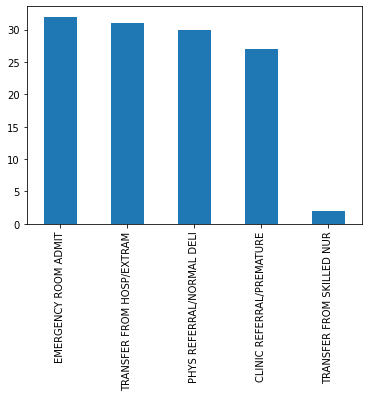

In [ ]:
train_data['admission_location'].value_counts().plot.bar()

<AxesSubplot:xlabel='admission_type', ylabel='admission_location'>

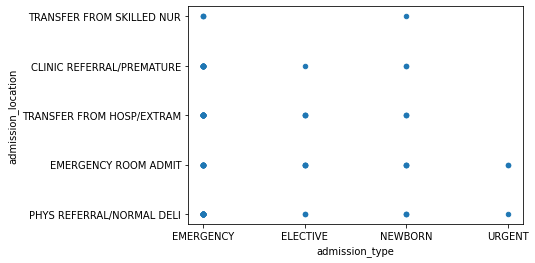

In [ ]:
sample.plot.scatter(x='admission_type',y='admission_location')

<AxesSubplot:xlabel='admission_type', ylabel='admission_location'>

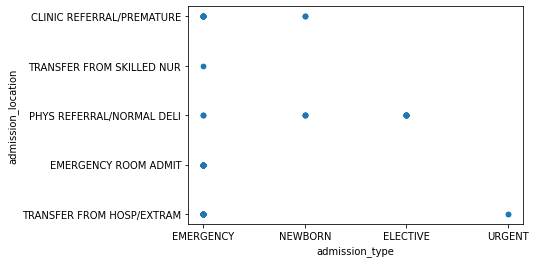

In [ ]:
train_data.plot.scatter(x='admission_type',y='admission_location')

In [ ]:
mostly_ai_data = pd.read_csv("test_syn.csv")

In [ ]:
sample.columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
       'edregtime', 'edouttime', 'has_chartevents_data',
       'hospital_expire_flag'],
      dtype='object')

In [ ]:
mostly_ai_data = mostly_ai_data.drop(['hospital_expire_flag'], axis=1)

In [ ]:
evaluate(mostly_ai_data, train_data.loc[:, mostly_ai_data.columns], metrics=['DiscreteKLDivergence'])

0.5564527888761744

In [ ]:
evaluate(sample.loc[:, mostly_ai_data.columns], train_data.loc[:, mostly_ai_data.columns], metrics=['DiscreteKLDivergence'])

0.434181554015113

In [ ]:
evaluate(mostly_ai_data, train_data.loc[:, mostly_ai_data.columns], metrics=['ContinuousKLDivergence'])

0.29878381842255286

In [ ]:
evaluate(sample.loc[:, mostly_ai_data.columns], train_data.loc[:, mostly_ai_data.columns], metrics=['ContinuousKLDivergence'])

0.5400340429220125